This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import Audio
from torchsummary import summary

#possibly unnecessary:
import torch.nn as nn
import torch.utils.data as data_utils
import logging
from torch import optim
from torchaudio import transforms
#import torchtext

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import Audio
from torchsummary import summary

#possibly unnecessary:
import torch.nn as nn
import torch.utils.data as data_utils
import logging
from torch import optim
from torchaudio import transforms
#import torchtext

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [3]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)


Change the `selected_language` to any of the 6 language codes, and re-run the cell below to hear some random clips from the training data.

In [4]:
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

Audio(X_train[idx], rate=sampling_rate)


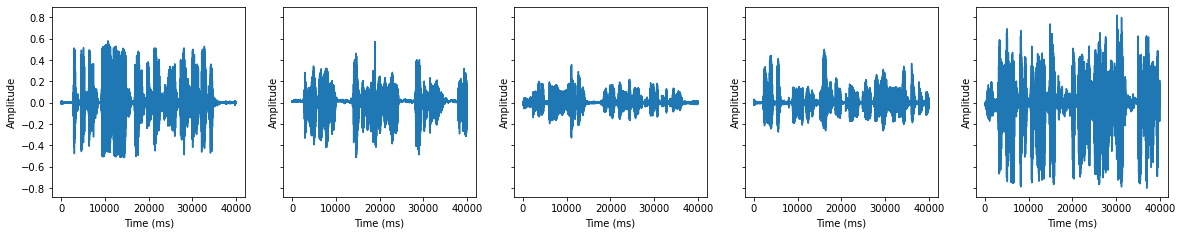

In [5]:
indexes_random = np.random.choice(6000, 5)

time = np.linspace(0, 39999, 40000)

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey = True)
for ax, audio_index in zip(axes,indexes_random):
    ax.plot(time, X_train[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [6]:
# normalization with MFCC

sample_rate = 40000/5
transform_MFCC = transforms.MFCC(sample_rate = sample_rate)

class MFCC(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        with torch.no_grad():
            x = transform_MFCC(x)
        return x
    
MFCC_transformation = MFCC()

In [7]:
#Isolating english and spanish for the initial model creation

idxs = np.where((y_train == language_dict['en'])|(y_train == language_dict['es'])) 
idxs_test = np.where((y_test == language_dict['en'])|(y_test == language_dict['es'])) 

y_train_sub = y_train[idxs]
X_train_sub = X_train[idxs]

y_test_sub = y_test[idxs_test]
X_test_sub = X_test[idxs_test]

print(np.shape(X_train_sub)) #samples, timesteps
print(np.shape(X_test_sub))


(2000, 40000)
(400, 40000)


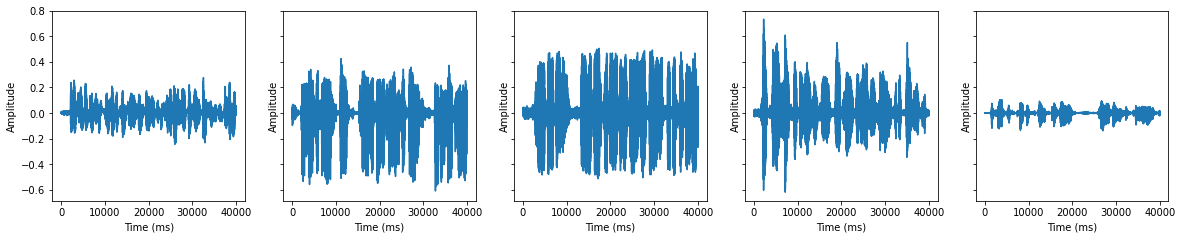

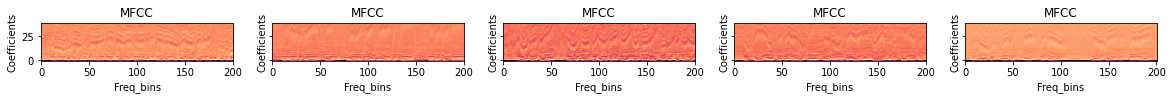

In [8]:
#"""
# transforming the dataset to MFCC

from matplotlib import cm

tensor_X_train = torch.tensor(X_train_sub)
transformed_tensor = MFCC_transformation(tensor_X_train)
transformed_array = np.array(transformed_tensor)


indexes = [100, 200, 300, 400, 500]

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True)
time = np.linspace(0, 39999, 40000)

for ax, audio_index in zip(axes,indexes):
    ax.plot(time, X_train_sub[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True)
for ax, audio_index in zip(axes,indexes):
    ax.imshow(transformed_array[audio_index], cmap=cm.magma, origin = 'lower')
    ax.set_xlabel('Freq_bins')
    ax.set_ylabel('Coefficients')
    ax.set_title("MFCC")
#"""

In [ ]:
'''
# Create a sequential model - CNN
model = nn.Sequential(MFCC_transformation)

in_size = MFCC_transformation(torch.tensor(X_train_sub)).shape[1]

# Add convolutional and pooling layers
#notebook used Conv2d and MaxPool2d 
model.add_module('Conv_1', nn.Conv3d(in_channels=in_size, out_channels=32, kernel_size=(3,3,3)))
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool3d(kernel_size=40))

model.add_module('Conv_2', nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3)))
model.add_module('Relu_2', nn.ReLU())
model.add_module('MaxPool_2', nn.MaxPool3d(kernel_size=2))

model.add_module('Conv_3', nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3)))
model.add_module('Relu_3', nn.ReLU())

model = model.to(device)

summary(model, input_size=(40,201)) #expects 40 but thinks it gets 2
'''

"\n# Create a sequential model - CNN\nmodel = nn.Sequential(MFCC_transformation)\n\nin_size = MFCC_transformation(torch.tensor(X_train_sub)).shape[1]\n\n# Add convolutional and pooling layers\n#notebook used Conv2d and MaxPool2d \nmodel.add_module('Conv_1', nn.Conv3d(in_channels=in_size, out_channels=32, kernel_size=(3,3,3)))\nmodel.add_module('Relu_1', nn.ReLU())\nmodel.add_module('MaxPool_1', nn.MaxPool3d(kernel_size=40))\n\nmodel.add_module('Conv_2', nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3)))\nmodel.add_module('Relu_2', nn.ReLU())\nmodel.add_module('MaxPool_2', nn.MaxPool3d(kernel_size=2))\n\nmodel.add_module('Conv_3', nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3)))\nmodel.add_module('Relu_3', nn.ReLU())\n\nmodel = model.to(device)\n\nsummary(model, input_size=(40,201)) #expects 40 but thinks it gets 2\n"

In [11]:
#we have a 2d dataset (images)
#if we want to consider rgb colors and thus a have a 3d shape with (channels, height, width)
#need to use a 2d convolution
#kernel applied to 3d input, so needs x*x but will actually be performing as x*x*x


# Create a sequential model - CNN
model = nn.Sequential(MFCC_transformation)

data_train = MFCC_transformation(torch.tensor(X_train_sub))  #2000 samples of 2d shape each: (40,201) aka height, width
data_test = MFCC_transformation(torch.tensor(X_test_sub)) #400 samples of 2d shape each: (40,201) aka height, width

'''
MFCC is the first layer of the model, so we shouldn't need to call X_train_3d on data_train, but otherwise the 
model somehow has irreperable issues. We probably only need it for the final data shape to set up the model.
But we still need to fact check this a bit later.
'''

#reshape data into existing amount (or remaining amount) of samples with 1 color channel (only red in our case) and of 40 by 201
X_train_sub_3d = data_train.reshape(-1, 1, 40, 201)
X_test_sub_3d = data_test.reshape(-1, 1, 40, 201)

print(X_train_sub_3d.shape) #checking that the reshaping worked
print(X_test_sub_3d.shape)


#'''
# Add convolutional and pooling layers
model.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(2,2), padding=200)) #groups=in_size_train,
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2,2), padding=1))
model.add_module('Relu_2', nn.ReLU())
model.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2,2), padding=1))
model.add_module('Relu_3', nn.ReLU())

model = model.to(device)
print(model)
summary(model, input_size = (1,40*201)) #(40,201))
#'''

torch.Size([2000, 1, 40, 201])
torch.Size([400, 1, 40, 201])
Sequential(
  (0): MFCC()
  (Conv_1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(200, 200))
  (Relu_1): ReLU()
  (MaxPool_1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Conv_2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (Relu_2): ReLU()
  (MaxPool_2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (Conv_3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (Relu_3): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              MFCC-1            [-1, 1, 40, 41]               0
            Conv2d-2         [-1, 32, 439, 440]             160
              ReLU-3         [-1, 32, 439, 440]               0
         MaxPool2d-4         [-1, 32, 220, 221]               0
            Conv2d-5         [-1, 64, 221, 222]     

In [23]:
BATCH_SIZE = 80 #64? 100?
training = torch.tensor(X_train_sub)
target = torch.tensor(y_train_sub)
train_dataset = data_utils.TensorDataset(training, target)
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#test_dataset = data_utils.TensorDataset(X_test_sub, y_test_sub)
#test_loader = data_utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = optim.RMSprop(model.parameters(), lr=0.001) 
crossentropy_loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 5
model.train() 

for epoch in range(num_epochs):
    for images, labels in train_loader: 
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()    

        #idk if these are needed, the are errors either way
        images = torch.randn(40, 40, 201)         
        labels = torch.randn(64, 2)
        
        predictions = model(images)     
        loss = crossentropy_loss(predictions, labels) 
        loss.backward() 
        optimizer.step()

model.eval() 
test_acc = 0 
for images, labels in test_loader: 
    images, labels = images.to(device), labels.to(device)
    predictions = model(images)
    accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
    test_acc += accuracy.item()
test_acc /= len(test_loader)



RuntimeError: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (200, 200) at dimension 2 of input [1, 321600, 2]

In [13]:
print(training.shape, target.shape)

torch.Size([2000, 40000]) torch.Size([2000])


In [14]:
# RNN (also code from notebooks)
# I have no idea whether this is okay

class Recurrent(nn.Module):
    """
    A class for a recurrent neural network model,
    a GRU/LSTM/RNN layer, and a linear output layer.

    Args:
        input_dim (int): The size of the input vocabulary.
        hidden_dim (int): The number of units in the hidden layer.
        output_dim (int): The size of the output vocabulary.
        recurrent (nn.GRU/nn.LSTM/nn.RNN): The type of recurrent layer to use.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, recurrent):
        super().__init__()
        self.recurrent = recurrent(input_dim, hidden_dim, num_layers=1)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):

        # RNN and GRU return a tuple of (output, h_n) where output has shape
        # (seq_len, batch, hidden_size)
        # and contains the sequence of activations in the final layer of the RNN
        # and h_n has shape (num_layers, batch, hidden_size)
        # and contains the set of activations at the final step in the sequences
        # for each layer
        # LSTM also returns c_n, the state of the memory cell, so we
        # need to adapt the code here.
        output, h_n = self.recurrent(data)

        if type(self.recurrent) == nn.LSTM:
            last = h_n[0][-1, :, :]
        else:
            last = h_n[-1, :, :]

        # We will apply the linear layer to the activation at the end of the
        # input sequence, for the last recurrent layer
        return self.linear(last)

In [15]:
# please check whether this is correct because idk
# it apparently cannot take a 2d shape as input_dim and output_dim, why?

input_dim = MFCC_transformation(torch.tensor(X_train_sub)).shape
output_dim = 1 # Binary classification, thus one dimensional output (0 or 1)

model_GRU = nn.Sequential(MFCC_transformation, Recurrent(input_dim[2], 32, output_dim, nn.GRU))
model_GRU = model_GRU.to(device)


In [25]:
#training = torch.tensor(X_train_sub)
#target = torch.tensor(y_train_sub)
#if torch.cuda.is_available():
#   model = model_GRU.cuda()
#   inputs = training.cuda() 
#   target = target.cuda()
#   print("cuda")
#model(training)

In [26]:
training = torch.tensor(X_train_sub)
target = torch.tensor(y_train_sub)
model_GRU = model_GRU.to(device)
model_GRU(training)

model_GRU.train() 

Sequential(
  (0): MFCC()
  (1): Recurrent(
    (recurrent): GRU(201, 32)
    (linear): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [39]:
#%pip install torchtext

     ---------------------------------------- 1.9/1.9 MB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 7.5 MB/s eta 0:00:00
  Using cached torch-2.0.0-cp39-cp39-win_amd64.whl (172.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\Applications\\anaconda\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [40]:
import logging
import torchtext
logging.basicConfig(level=logging.INFO)

BATCH_SIZE = 16

train_it, val_it = torchtext.data.Iterator.splits(
    (X_train_sub, X_test_sub), 
    batch_size = BATCH_SIZE,
    device = device)

def train(model, train_it, val_it, optimizer, epochs=10):
    ### PUT YOUR CODE HERE ###

    """Train `model` in batches from `iterator` and return training loss and 
    accuracy."""
    epoch_loss = 0
    epoch_acc = 0 
    record = {}

    model.train() # Enable training mode (for things which differ between training and testing such as dropout)
    for batch in train_it:
        optimizer.zero_grad()
        print(batch)
        text, prev, curr = batch
        pred = model(text, prev)
        loss = criterion(pred, curr)
        record['loss'] = loss
        # We can calculate accuracy by taking the argmax of the logits and comparing with labels.
        acc = accuracy(pred, curr) 
        record['acc'] = acc
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        record['e_loss'] = epoch_loss
        epoch_acc += acc
        record['e_acc'] = epoch_acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def param_count(params):
  """Return the number of total parameters."""
  return sum(p.nelement() for p in params)
acc = []
val_acc = []
loss = []
val_loss = []


model = model_GRU
optimizer = torch.optim.Adam(model.parameters())
logging.info(f"Recurrent GRU")
logging.info(f"    Total parameters: {param_count(model.parameters()):10d}")
logging.info(f"Recurrent parameters: {param_count(model.parameters()):10d}")
history = train(model, train_it, val_it, optimizer, epochs=15)
acc.append(history['acc'])
val_acc.append(history['val_acc'])
loss.append(history['loss'])
val_loss.append(history['val_loss'])

ModuleNotFoundError: No module named 'torchtext'

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [ ]:
torch.jit.save(torch.jit.script(model), "model_test.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [ ]:
model = torch.jit.load("model_test.pt")

In [ ]:
model(inputs)

### Making a PCA plot of the output space

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [ ]:
model_outputs = torch.randn(1200, 6)
targets = torch.randint(0, 6, (1200,))

In [ ]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs)

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);